In [1]:
from utils import *
from main import cluster_eval
from datasets import load_dataset

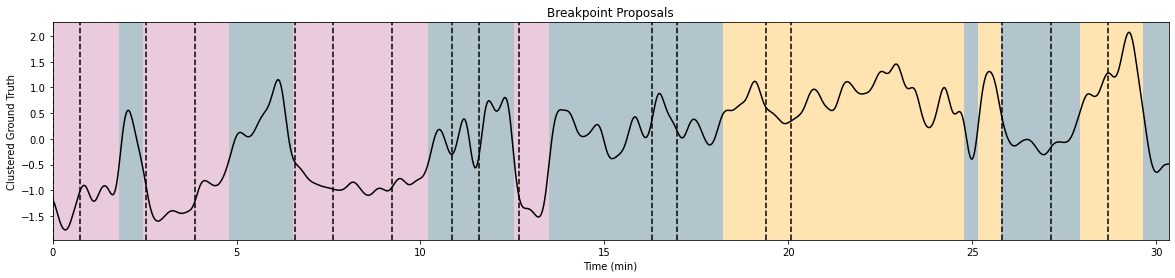

participant_1 0.654


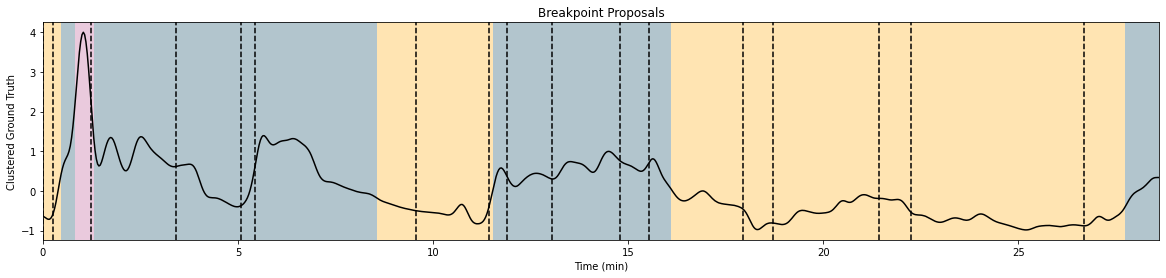

participant_2 0.82


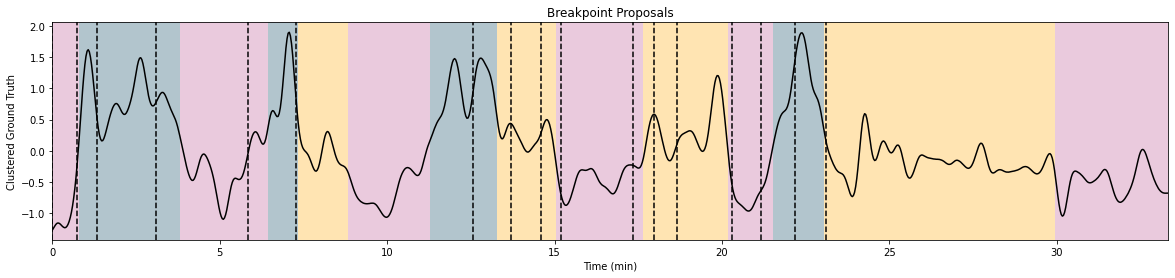

participant_3 0.618


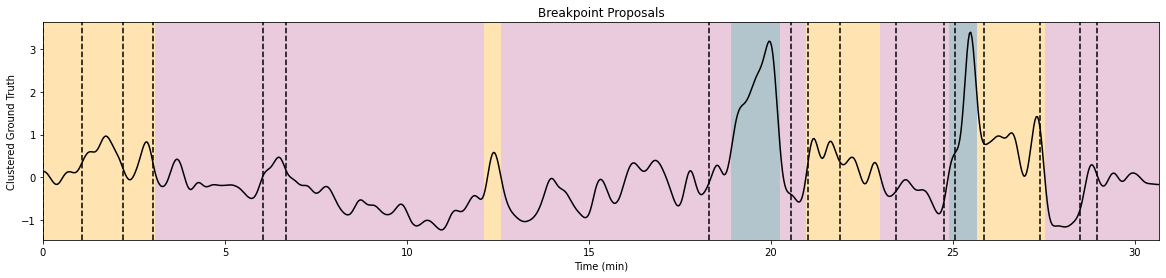

participant_4 0.673


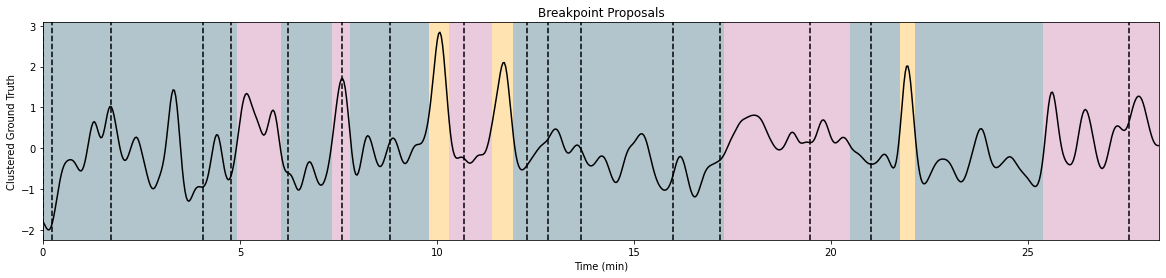

participant_5 0.681


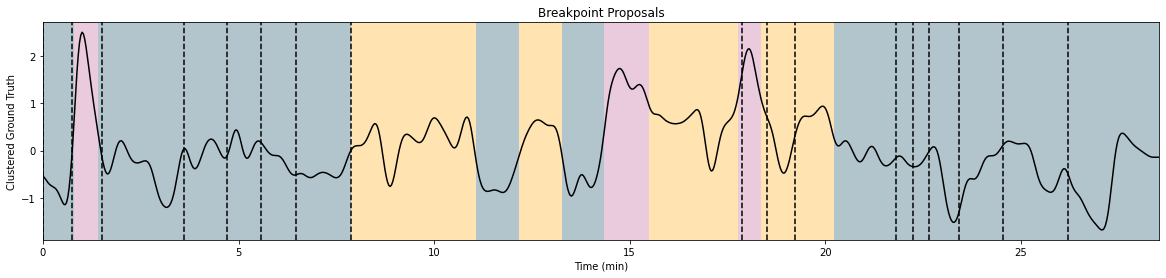

participant_6 0.645


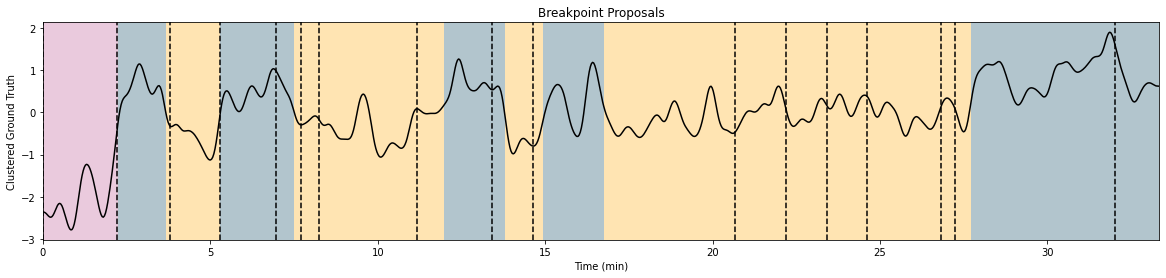

participant_7 0.797


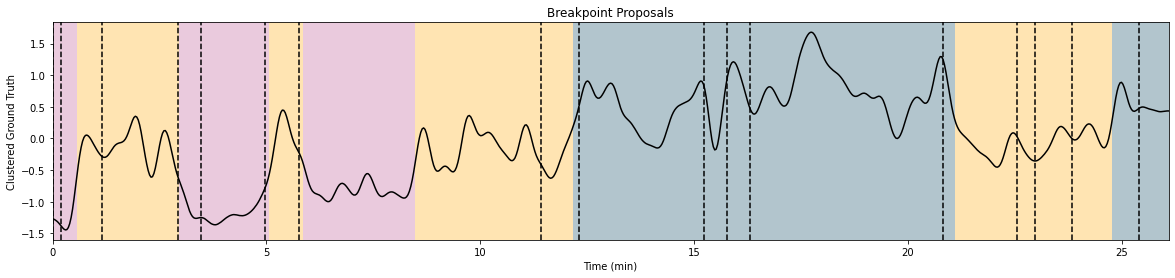

participant_8 0.785


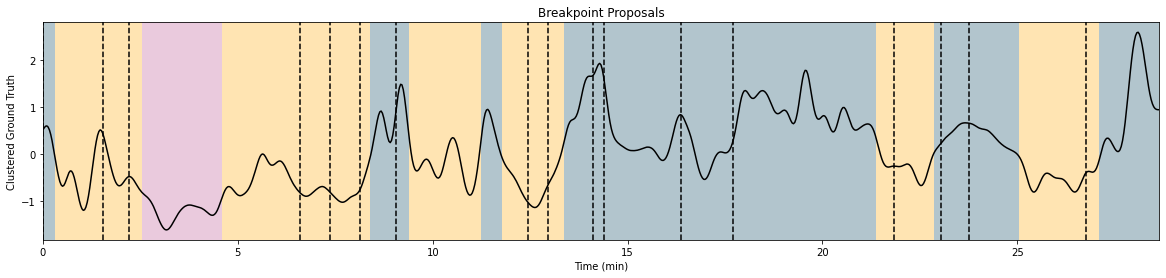

participant_9 0.655


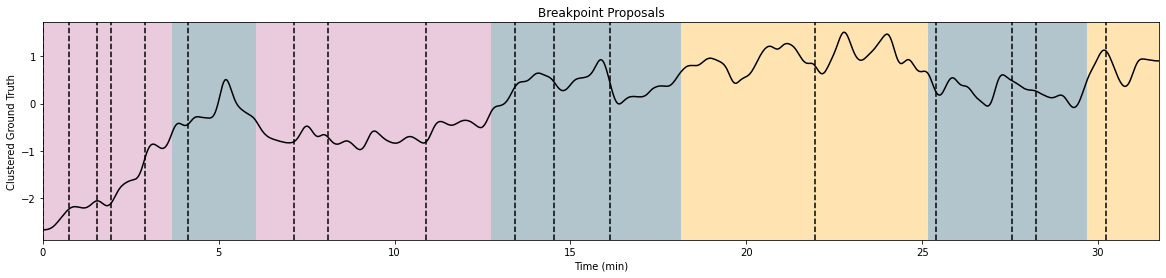

participant_10 0.729
{'participant_1': 0.654, 'participant_2': 0.82, 'participant_3': 0.618, 'participant_4': 0.673, 'participant_5': 0.681, 'participant_6': 0.645, 'participant_7': 0.797, 'participant_8': 0.785, 'participant_9': 0.655, 'participant_10': 0.729, 'mean': 0.706, 'std': 0.068}


In [2]:
basepath = "/home/kavra/Datasets/"
data, gt_data, names = load_dataset(
    #basepath + "physionet.org/files/drivedb/1.0.0/",
    basepath + "hcilab_driving_dataset/",
    "HCIDriving",
    0,
    0.5,
    "Fused",
    ["HR"],
)

scores, compute_avg = dict(), list()
for i in range(len(names)):
    score = cluster_eval(
        gt_data[i],
        gt_bps=apply_ggs(gt_data[i], kmax=16, lmbda=15),
        bps=apply_ggs(data[i].to_numpy(), kmax=16, lmbda=15),
        n_clusters=3,
        plot=True
    )

    compute_avg.append(score)
    scores[names[i]] = np.around(score, 3)
    print(names[i], scores[names[i]])
    
scores["mean"] = np.around(np.mean(compute_avg), 3)
scores["std"] = np.around(np.std(compute_avg), 3)
print(scores)

### MuSe (ignore for now)

* Modalities: HR, RESP_rate (+++)
* Additional: Golden standard of arousal + EDA
* Initial fs: 2 Hz --> used as is

In [ ]:
muse_path = "/home/kavra/Repos/MuSe2022/muse_stress_2022/"
ft_path = muse_path + "feature_segments/"
lb_path = muse_path + "label_segments/physio-arousal/"
pt = pd.read_csv(muse_path + "metadata/partition.csv")

for p in os.listdir(ft_path + "BPM/"):
    
    ### label loading
    num = int(p.split(".")[0])
    if pt.loc[pt["Id"] == num]["Partition"].item() == "test":
        continue
    gt_data = pd.read_csv(lb_path + p)[["value"]].to_numpy().squeeze()
    
    ### data loading
    bpm = pd.read_csv(ft_path + "BPM/" + p)[["BPM"]].to_numpy()
    rsp_r = pd.read_csv(ft_path + "resp_rate/" + p)[["resp_amp"]].to_numpy()
    rsp = pd.read_csv(ft_path + "resp/" + p)[["resp"]].to_numpy()

    ### ggs on streams
    data = np.hstack([bpm, rsp])
    bps = apply_ggs(data, 20, 1)
    plot_ggs(data, bps)

    ### ggs on ground truth
    gt_bps = apply_ggs(gt_data, 20, 1)
    X = segment_ts(gt_data, gt_bps)

    ### ground truth clustering
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
    clusters = model.fit_predict(X)
    plot_cluster(gt_data, gt_bps, clusters)

    ### jaccard evaluation
    old = gt_bps.copy()
    for i in range(1, len(old)-1):
        if clusters[i] == clusters[i-1]:
            gt_bps.remove(old[i])
    print(
        "Cover:", covering_metric(bps, gt_bps, len(gt_signal))
    )

### AffectiveROAD

##### Bioharness

* Modalities: HR, RESP_rate + Activity (temp ground truth) + Posture
* Additional: Annotation of Driving Route
* Initial fs: 1 Hz --> LP filter at 0.05 Hz and resample to 0.5 Hz
* Ground truth further filter at 0.01 Hz for smoothing

##### Empatica 4

* Modalities: HR, EDA (ground truth), BVP, TEMP
* Additional: Annotation of Driving Route
* Initial fs: various Hz --> LP filter at 0.1 Hz and resample to 0.5 Hz
* Ground truth further filter at 0.01 Hz for smoothing

##### Subjective Measures

* Modalities: Stress Rating (ground truth)
* Additional: Annotation of Driving Route
* Initial fs: 4 Hz (?) --> LP filter at 0.01 Hz and resample to 0.5 Hz

In [50]:
# TODO: combine folders and use route data
base_path = "/home/kavra/Datasets/AffectiveROAD/Database/"

bio_path = base_path + "Bioharness/"
e4_path = base_path + "E4/"
sm_path = base_path + "Subj_metric/"

bio_annot = bio_path + "Annot_Bioharness.csv"
e4_annot_l = e4_path + "Annot_E4_Left.csv"
e4_annot_r = e4_path + "Annot_E4_Left.csv"
sm_annot = sm_path + "Annot_Subjective_metric.csv"

#### Empatica 4

In [ ]:
hand = "Left"
for drive in os.listdir(e4_path):
    if "Drv" not in drive:
        continue

    e4_data = {}
    this_path = os.path.join(e4_path, drive, hand)
    for rec in os.listdir(this_path):
        if any(s in rec for s in ["txt", "tags", "IBI", "ACC"]):
            continue

        ### data loading
        data_path = os.path.join(this_path, rec)
        data = pd.read_csv(data_path, delimiter=",")

        fs = data.iloc[0].values[0]
        data = data.iloc[1:]
        name = rec.split(".")[0]
        data.columns = [name]

        ### lowpass filter (0.25Hz) + downsample to 0.5Hz
        data.index = pd.date_range(start='1/1/2022', periods=len(data), freq=f'{1/fs}S')
        b, a = butter(3, 0.1, fs=float(fs), btype='low')
        data[name] = filtfilt(b, a, data.to_numpy().squeeze())
        e4_data[name] = data.resample("2S").mean().to_numpy().squeeze()

    ### sychronization - HR has 10sec (5 samples) delay
    len_hr = int(len(e4_data["HR"]))
    e4_data = {
        name: e4_data[name][-len_hr:] for name in e4_data
    }    
    e4_data = pd.DataFrame(e4_data)

    ### apply GGS and get breakpoints
    this_data = e4_data[["HR", "BVP"]].to_numpy()
    bps = apply_ggs(this_data, 20, 1)
    plot_ggs(this_data, bps)

    ### specify ground truth and smooth
    gt_signal = e4_data["EDA"].to_numpy()
    gt_signal = lowpass_filter(gt_signal, freq=0.5, cut=0.01)
    gt_bps = apply_ggs(gt_signal, 20, 1)

    ### ground truth clustering
    X = segment_ts(gt_signal, gt_bps)
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
    clusters = model.fit_predict(X)
    plot_cluster(gt_signal, gt_bps, clusters)

#### Bioharness

In [ ]:
def lowpass_filter(ts=None, freq=1, cut=0.05):
    b, a = butter(3, cut, fs=freq, btype='low')
    return filtfilt(b, a, ts)

for drive in os.listdir(bio_path)[12:]:
    if not drive.startswith("Bio"):
        continue
    print(drive)

    ### data loading
    data = pd.read_csv(bio_path + drive, delimiter=";")
    data["Time"] = pd.to_datetime(data[data.columns[0]])
    if data.columns[0] != "Time":
        data = data.drop(columns=[data.columns[0]], axis=1)
    data = data.drop_duplicates().set_index("Time")

    ### lowpass filter (0.05Hz) + downsample to 0.5Hz
    data = data.apply(lowpass_filter).resample("2S").mean()

    ### apply GGS and get breakpoints
    this_data = data[["HR", "BR"]].to_numpy()
    bps = apply_ggs(this_data, 20, 1)
    #plot_ggs(this_data, bps)

    ### specify ground truth and smooth
    gt_signal = data["Activity"].to_numpy()
    gt_signal = lowpass_filter(gt_signal, freq=0.5, cut=0.01)
    gt_bps = apply_ggs(gt_signal, 20, 1)

    ### ground truth clustering
    X = segment_ts(gt_signal, gt_bps)
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
    clusters = model.fit_predict(X)
    #plot_cluster(gt_signal, gt_bps, clusters)

    ### jaccard evaluation
    old = gt_bps.copy()
    for i in range(1, len(old)-1):
        if clusters[i] == clusters[i-1]:
            gt_bps.remove(old[i])
    print(
        "Cover:", covering_metric(bps, gt_bps, len(gt_signal))
    )

#### Subjective Measures

In [ ]:
def lowpass_filter(ts=None, freq=4, cut=0.01):
    b, a = butter(3, cut, fs=freq, btype='low')
    return filtfilt(b, a, ts)

for drive in os.listdir(sm_path):
    if not drive.startswith("SM"):
        continue

    ### data loading
    data = pd.read_csv(sm_path + drive, delimiter=";")
    data.index = pd.date_range(start='1/1/2022', periods=len(data), freq=f'0.25S') # NOT SURE ABOUT fs

    ### lowpass filter (0.25Hz) + downsample to 0.5Hz
    data = data.apply(lowpass_filter).resample("2S").mean()

    ### specify ground truth + apply ggs
    gt_signal = data.to_numpy().squeeze()
    gt_bps = apply_ggs(gt_signal, 20, 1)

    ### ground truth clustering
    X = segment_ts(gt_signal, gt_bps)
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
    clusters = model.fit_predict(X)
    plot_cluster(gt_signal, gt_bps, clusters)

### RECOLA (TBD)

In [7]:
def load_RECOLA_feat(path, sub="1"):
    data = arff.loadarff(f"{path}P{sub}.arff")
    return pd.DataFrame(data[0])

def load_AVEC_feat(path, partition, sub="1"):
    assert partition in ["train", "dev", "test"]
    data = arff.loadarff(f"{path}/{partition}_{sub}.arff")
    return pd.DataFrame(data[0])

def load_AVEC_rec(path, partition, sub="1"):
    assert partition in ["train", "dev", "test"]
    return pd.read_csv(f"{path}/{partition}_{sub}.csv", delimiter=";")

In [ ]:
path = "/home/kavra/Datasets/RECOLA/AVEC16/recordings/recordings_physio/filtered/"
for partition in ["train", "dev", "test"]:
    for i in range(1, 9):
        # HRV being the 1st-order derivative of HR (from ECG)
        this_df = load_AVEC_rec(path, partition, sub=str(i))
        this_df.index = pd.date_range(start='1/1/2022', periods=len(this_df), freq='0.004S')
        this_df = this_df.resample("0.2S").mean()

        this_data = this_df[["HRV"]].to_numpy()
        this_data = this_data.T if len(this_data.shape) != 1 else this_data[None, ...]
        bps, _ = GGS(this_data, Kmax=20, lamb=5)

        plot_ggs(this_data.T, bps)
        plot_ggs(this_df["EDA"].to_numpy(), bps)